In [46]:
from google.colab import files
files.upload()



Saving kaggle.json to kaggle (1).json


{'kaggle (1).json': b'{"username":"kavipurapuharini","key":"8712380750eaa2572b4a4bbba2945703"}'}

In [47]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c dogs-vs-cats

mkdir: cannot create directory ‘/root/.kaggle’: File exists
dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


In [48]:
!unzip -qq dogs-vs-cats.zip

replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [49]:
!unzip -qq train.zip

replace train/cat.0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [55]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir,exist_ok=True)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1500, end_index=2000)
make_subset(subset_name="test", start_index=2500, end_index=3000)

In [56]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [57]:

model.summary()

Model: "functional_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)           │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_3 (Rescaling)              │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 18, 18, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 9, 9, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 7, 7, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │          12,545 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 991,041 (3.78 MB)

 Trainable params: 991,041 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [60]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 16000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [61]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [62]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [63]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [64]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


In [65]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


In [66]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 31s 58ms/step - accuracy: 0.5425 - loss: 0.6949 - val_accuracy: 0.6420 - val_loss: 0.6496
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 36s 50ms/step - accuracy: 0.7092 - loss: 0.5626 - val_accuracy: 0.7645 - val_loss: 0.4826
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 43s 53ms/step - accuracy: 0.7803 - loss: 0.4675 - val_accuracy: 0.8090 - val_loss: 0.3905
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 53ms/step - accuracy: 0.8316 - loss: 0.3738 - val_accuracy: 0.8670 - val_loss: 0.3146
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - accuracy: 0.8732 - loss: 0.3031 - val_accuracy: 0.8450 - val_loss: 0.3776
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 43s 55ms/step - accuracy: 0.8977 - loss: 0.2428 - val_accuracy: 0.9040 - val_loss: 0.2402
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 49ms/step - accuracy: 0.9198 - loss: 0.1955 - val_accuracy: 0.9085 - val_loss: 0.2276
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 50ms/step - accuracy: 0.9341 - loss: 0.1560 - 

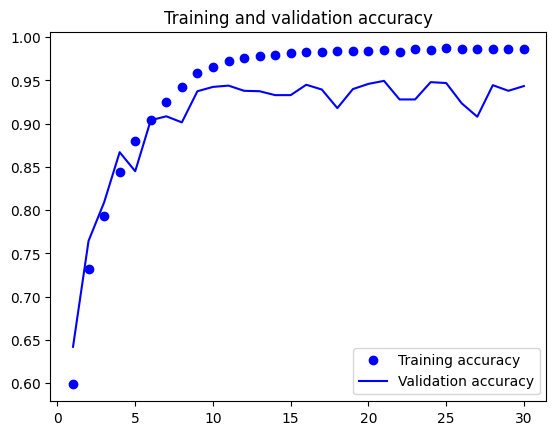

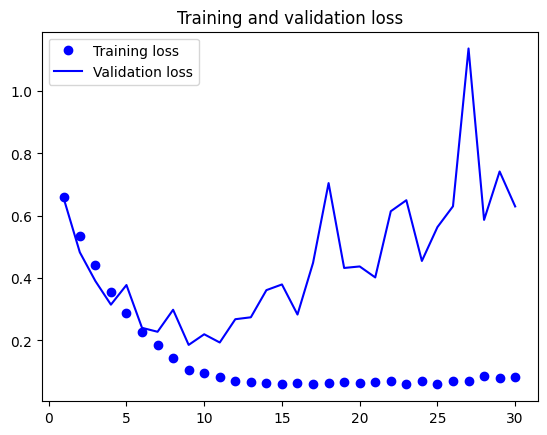

In [67]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [68]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9282 - loss: 0.2083
Test accuracy: 0.927


In [69]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

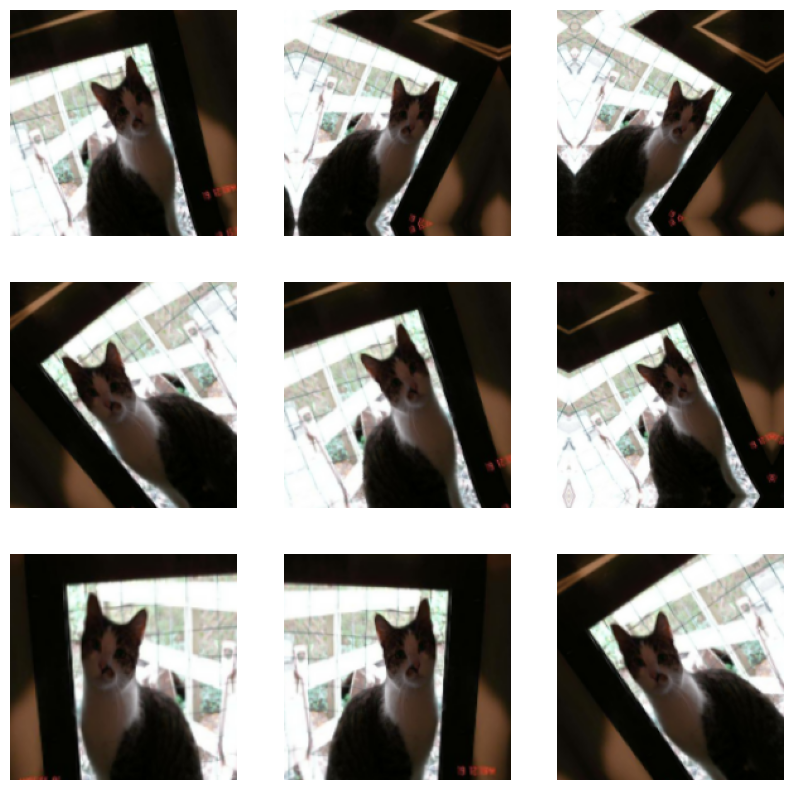

In [70]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [71]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [72]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=100,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 29s 53ms/step - accuracy: 0.5414 - loss: 0.6859 - val_accuracy: 0.6820 - val_loss: 0.5968
Epoch 2/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 28s 55ms/step - accuracy: 0.6626 - loss: 0.6227 - val_accuracy: 0.7015 - val_loss: 0.5841
Epoch 3/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 26s 51ms/step - accuracy: 0.7148 - loss: 0.5543 - val_accuracy: 0.7855 - val_loss: 0.4738
Epoch 4/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 55ms/step - accuracy: 0.7639 - loss: 0.5018 - val_accuracy: 0.7900 - val_loss: 0.4654
Epoch 5/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 41s 56ms/step - accuracy: 0.7791 - loss: 0.4692 - val_accuracy: 0.8345 - val_loss: 0.3853
Epoch 6/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 38s 50ms/step - accuracy: 0.8032 - loss: 0.4252 - val_accuracy: 0.8460 - val_loss: 0.3571
Epoch 7/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 43s 54ms/step - accuracy: 0.8265 - loss: 0.3887 - val_accuracy: 0.8275 - val_loss: 0.4480
Epoch 8/100
500/500 ━━━━━━━━━━━━━━━━━━━━ 40s 53ms/step - accuracy: 0.8467 - loss: 0

In [76]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9124 - loss: 0.1715
Test accuracy: 0.914


In [78]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [79]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)          │ (None, 180, 180, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 180, 180, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 180, 180, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 90, 90, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 90, 90, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 90, 90, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 45, 45, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 45, 45, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 45, 45, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 22, 22, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 22, 22, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 22, 22, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 11, 11, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 11, 11, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 5, 5, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [80]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 470ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━

In [81]:
train_features.shape

(16000, 5, 5, 512)

In [82]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=20,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9320 - loss: 18.8388 - val_accuracy: 0.9790 - val_loss: 1.9877
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9810 - loss: 2.3434 - val_accuracy: 0.9840 - val_loss: 1.7233
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9843 - loss: 1.2021 - val_accuracy: 0.9875 - val_loss: 1.1325
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9886 - loss: 0.8646 - val_accuracy: 0.9815 - val_loss: 1.5543
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9866 - loss: 0.9621 - val_accuracy: 0.9870 - val_loss: 0.8689
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9917 - loss: 0.4062 - val_accuracy: 0.9915 - val_loss: 0.6416
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9917 - loss: 0.4291 - val_accuracy: 0.9910 - val_loss: 0.7226
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9932 - loss: 0.3724 - val_accuracy: 0

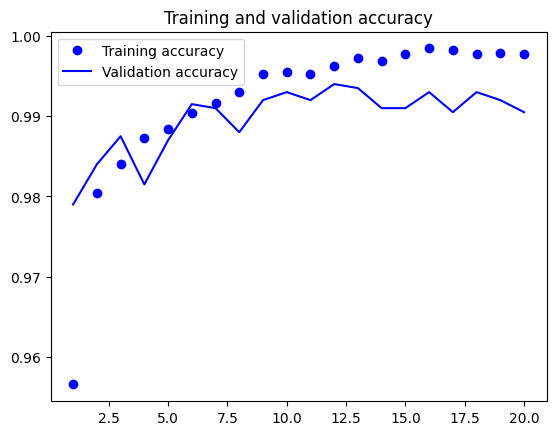

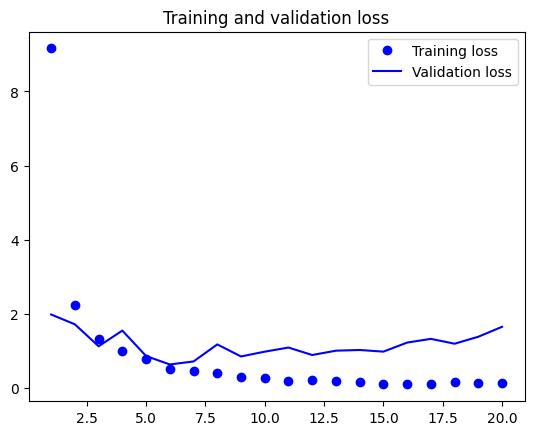

In [83]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [84]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [85]:
conv_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [86]:
conv_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


In [87]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [88]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 70s 135ms/step - accuracy: 0.9168 - loss: 16.6859 - val_accuracy: 0.9810 - val_loss: 1.8641
Epoch 2/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 85s 142ms/step - accuracy: 0.9540 - loss: 3.5657 - val_accuracy: 0.9825 - val_loss: 0.5115
Epoch 3/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 79s 137ms/step - accuracy: 0.9547 - loss: 1.0740 - val_accuracy: 0.9825 - val_loss: 0.3077
Epoch 4/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 81s 136ms/step - accuracy: 0.9534 - loss: 0.7234 - val_accuracy: 0.9805 - val_loss: 0.3919
Epoch 5/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 83s 137ms/step - accuracy: 0.9604 - loss: 0.6649 - val_accuracy: 0.9850 - val_loss: 0.2958
Epoch 6/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 84s 142ms/step - accuracy: 0.9604 - loss: 0.7351 - val_accuracy: 0.9845 - val_loss: 0.3287
Epoch 7/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 79s 136ms/step - accuracy: 0.9610 - loss: 0.7139 - val_accuracy: 0.9870 - val_loss: 0.3263
Epoch 8/50
500/500 ━━━━━━━━━━━━━━━━━━━━ 68s 136ms/step - accuracy: 0.9653 - loss: 

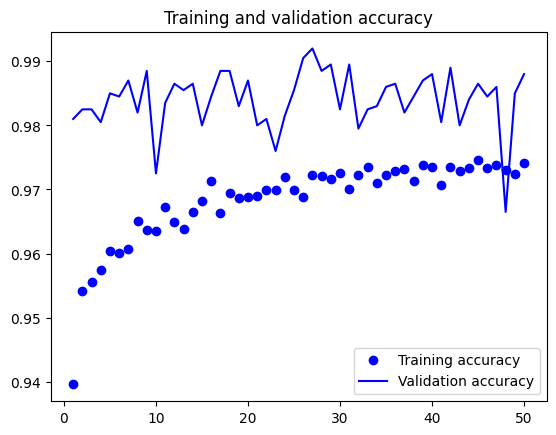

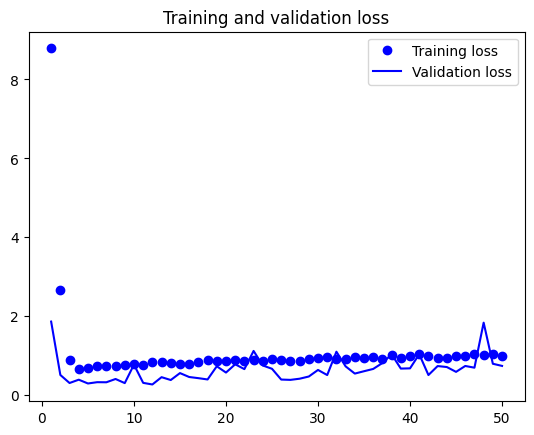

In [89]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [90]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - accuracy: 0.9750 - loss: 0.6739
Test accuracy: 0.979


In [91]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)          │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [92]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [93]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001) # Changed lr to learning_rate
model.compile(loss="binary_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 86s 168ms/step - accuracy: 0.5167 - loss: 13.5201 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 135s 155ms/step - accuracy: 0.4958 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 3/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 156ms/step - accuracy: 0.4923 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 4/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 155ms/step - accuracy: 0.4991 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 5/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 85s 162ms/step - accuracy: 0.4915 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 6/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 78s 156ms/step - accuracy: 0.4961 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 7/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 155ms/step - accuracy: 0.4929 - loss: 0.6934 - val_accuracy: 0.5000 - val_loss: 0.6933
Epoch 8/30
500/500 ━━━━━━━━━━━━━━━━━━━━ 82s 155ms/step - accuracy: 0.4964 - loss:

In [94]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - accuracy: 0.4986 - loss: 0.6932
Test accuracy: 0.500
